# Lab 15b: Online Reallocation of Minimum Variance Portfolios
The objective of `Lab 15b` is to familiarize students with `active` fund management using your initial project portfolios. In `Lab 15b`, we'll implement a fund management strategy discussed in the lecture. Namely, we'll reallocate the portfolio after the close of every trading day.

## Assumptions
We'll make several assumptions in `Lab 15b` to simply the calculations, many of which are `not` true in practice:
* __Assumption 1__: The covariance matrix is constant and can be described using the backward-looking single index model approximation (estimated using `2018` to `2022` data).
* __Assumption 2__: Ignore taxes, commissions, and other sources of market friction, e.g., overnight or weekend price changes to the components of our portfolio. 

## Tasks

* __Task 1__: Load the Efficient Frontier Collection and Select an Initial Portfolio
    * `TODO`: Specify a value for the `total_initial_budget` variable
    * `TODO`: Copy your efficient frontier file generated from `THP3/PD1` (or generate it now if you have not done so) into the `data` subdirectory
    * `TODO`: Specify which initial portfolio you wish to select from the efficient frontier collection
* __Task 2__: Reallocate your portfolio after the close everyday
    * `TODO`: Specify the `number_of_trading_days` you wish to simulate (up to `221`)
    * `TODO`: Specify a value for the learning rate parameter $\alpha\geq{0}$
    * `TODO`: Specify the minimum desired return in the `minimum_desired_return` variable
* __Task 3__: Visualize the performance of the original portfolio, the reallocated portfolio, and the benchmark portfolio `SPY`.
    * `Discussion`: Contrast the performance of the original portfolio with the reallocated portfolio. What is happening in the reallocation process - explain to each other what you believe is happening
        * `Hint`: Check out the `share_volume_array` (after the plots), which holds the shares in the reallocated portfolio.* `Hint`: Check out the `share_volume_array` (after the plots), which holds the shares in the reallocated portfolio.

## Setup

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-Examples-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`


## Prerequisites: Load historical dataset, compute expected returns and covariance
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `11-17-2023`, along with data for a few exchange traded funds and volatility products during that time. 

In [2]:
original_dataset = load(joinpath(_PATH_TO_DATA, 
        "SP500-Daily-OHLC-1-3-2018-to-11-17-2023.jld2")) |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Let's get a list of firms that we have in cleaned up `dataset`, and save it in the `all_tickers` array:

In [5]:
all_tickers = keys(dataset) |> collect |> sort;
K = length(all_tickers);

### Get the 2023 `SPY` data

In [6]:
startdate = Date(2021,01,03);
SPY_dataset = dataset["SPY"];
SPY_df = filter(:timestamp => x-> x >= startdate, SPY_dataset);

### Compute the covariance and expected yield for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll provide values for both of these items for the entire data set (all `N = 459` tickers), and then you can pick out which tickers you are interested in. 

* First, we compute the expected (annualized) log return by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the `log_return_matrix(...)` method. The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time-value, while each column corresponds to a firm:

In [7]:
all_firms_return_matrix = log_return_matrix(dataset, all_tickers, 
    Δt = (1.0/252.0), risk_free_rate = 0.0);

In [8]:
μ = mean(all_firms_return_matrix, dims=1) |> vec;

### Build single index model approximation of the covariance

In [9]:
sims = load(joinpath(_PATH_TO_DATA, "SIMs-PortfolioDriftExample-PD1-CHEME-5660-Fall-2023.jld2")) |> x->x["sims"];

In [10]:
index_SPY = findfirst(x->x=="SPY", all_tickers);
r_SPY = μ[index_SPY]

0.08726475731522582

Next let's build the `single index model` version of the covariance array. Substituting the single index model for the excess return of asset $i$ and $j$ into the covariance expression (and simplifying) gives:

$$
\begin{equation*}
\text{cov}(R_{i}, R_{j}) = \begin{cases}
\beta_{i}^{2}\sigma_{m}^{2}+\sigma_{\epsilon_{i}}^{2} & i = j \\
\beta_{i}\beta_{j}\sigma_{m}^2 & i \neq j
\end{cases}
\end{equation*}
$$

where $\sigma_{m}^2$ denotes the variance of the excess return of the market,  and $\sigma_{\epsilon_{i}}^{2}$ denotes the variance of the firm-specific error model.

In [11]:
σₘ = std(all_firms_return_matrix[:, index_SPY])

2.5414369559913688

We populate the single index covariance array using nested `for` loops:

In [12]:
Σ_tmp = Array{Float64,2}(undef, length(μ), length(μ));
for i ∈ eachindex(all_tickers)
    outer_ticker = all_tickers[i];
    sim_outer = sims[outer_ticker];
    
    for j ∈ eachindex(all_tickers)
        
        inner_ticker = all_tickers[j];
        sim_inner = sims[inner_ticker];
        
        if (i == j)
            βᵢ = sim_outer.β
            ϵᵢ = sim_outer.ϵ
            σ_ϵᵢ = params(ϵᵢ)[2];
            Σ_tmp[i,j] = ((βᵢ)^2)*((σₘ)^2)+(σ_ϵᵢ)^2
        else
            βᵢ = sim_outer.β
            βⱼ = sim_inner.β
            Σ_tmp[i,j] = βᵢ*βⱼ*(σₘ)^2
        end
    end
end
Σ_sim  = Σ_tmp |> x-> x*(1/252);

## Task 1: Load the Efficient Frontier Collection and Select an Initial Portfolio

`TODO`: Specify a value for the `total_initial_budget` variable:

In [13]:
total_initial_budget = 1000.0; 

`TODO`: Copy your efficient frontier file generated from `THP3/PD1` (or generate it now if you have not done so) into the `data` subdirectory, and update the filename in the expression below:

In [14]:
efficient_frontier = load(joinpath(_PATH_TO_DATA,
        "EfficientFrontier-PortfolioDriftExample-PD1-CHEME-5660-Fall-2023.jld2")) |> x->x["dataset"]

Row,expected_excess_return,risk,tickers,w,risk_free_rate
,Float64,Float64,Array…,Array…,Float64
1,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80373e-8, 9.59536e-8, 4.84921e-7, 0.506115]",0.05
2,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80373e-8, 9.59536e-8, 4.85803e-7, 0.506115]",0.05
3,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80373e-8, 9.59537e-8, 4.87577e-7, 0.506115]",0.05
4,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80374e-8, 9.59542e-8, 5.32657e-7, 0.506115]",0.05
5,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80382e-8, 9.59546e-8, 5.69075e-7, 0.506115]",0.05
6,0.0388449,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80362e-8, 9.59585e-8, 1.40028e-6, 0.506114]",0.05
7,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299102, 7.80366e-8, 9.59546e-8, 5.08398e-7, 0.506115]",0.05
8,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299102, 7.80371e-8, 9.59552e-8, 5.25002e-7, 0.506115]",0.05
9,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299102, 7.80333e-8, 9.60306e-8, 1.00265e-6, 0.506114]",0.05


`TODO`: Specify which initial portfolio you wish to select, by setting the value of the `portfolio_index` variable:

In [15]:
portfolio_index = 13;

In [16]:
my_list_of_tickers = efficient_frontier[portfolio_index,:tickers];
w = efficient_frontier[portfolio_index,:w] .|> x-> round(x,digits=6) .|> abs;
risk = efficient_frontier[portfolio_index,:risk] .|> x-> round(x,digits=6) .|> abs;
expected_excess_return = efficient_frontier[portfolio_index,:expected_excess_return] |> x-> round(x,digits=3)
println("The expected excess return for portfolio $(portfolio_index) equals $(expected_excess_return) with risk = $(risk)")

The expected excess return for portfolio 13 equals 0.055 with risk = 0.153249


#### What is in this portfolio?

In [17]:
tmp_df = DataFrame();
for i ∈ eachindex(w)
    wᵢ = w[i];
    row_df = (
        ticker = my_list_of_tickers[i],
        allocation = wᵢ
    );
    push!(tmp_df, row_df);
end
tmp_df

Row,ticker,allocation
,String,Float64
1,PFE,0.183685
2,MRK,0.417142
3,AMD,0.028544
4,MU,0.0
5,INTC,0.0
6,SPY,0.370628


### Compute the number of shares of each asset in your initial portfolio

Get the `close` share price for each asset in the portfolio for the `startdate`. We'll store these values in the `Sₒ::Array{Float64,1}` variable:

In [18]:
Sₒ = Array{Float64,1}() # these are close prices at the end of Jan 3, 2023
for ticker ∈ my_list_of_tickers
    price_df = dataset[ticker];
    startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:close] 
    push!(Sₒ,startprice)
end

Now that we have the `total_budget`, and the share price array `Sₒ`, we compute the number of shares of each asset that corresponds to the optimal allocation (the point in the efficient frontier) and store these values in the `Nₒ::Array{Float64,1}` variable (in this case, we allow for fractional shares):

In [19]:
Nₒ = Array{Float64,1}()
for i ∈ eachindex(w)
    
    wᵢ = w[i]
    nᵢ = (wᵢ*total_initial_budget)/Sₒ[i];
    push!(Nₒ,nᵢ)
end
Nₒ

6-element Vector{Float64}:
 4.9900842162455845
 5.152445652173913
 0.3092524377031419
 0.0
 0.0
 1.0049838661568913

## Task 2: Reallocate your portfolio after the close every day
In `task 2` we'll solve the Minimum Variance allocation problem to estimate the dollar fractions $\omega_{i}$ for each portfolio component. We'll keep the covariance matrix $\hat{\Sigma}$ the same but update the `expected return` using current market data. In particular, suppose we update the expected return after each trading data using the update rule (incremental average):

$$
\hat{\mu}_{i,k} = \hat{\mu}_{i,k-1} + \alpha\cdot\left(\mu_{i,k}-\hat{\mu}_{i,k-1}\right)\qquad{i\in\mathcal{P}}
$$

where $\hat{\mu}_{i,k}$ denotes the estimated average return for asset $i$ at time $k$, $\mu_{i,k}$ denotes the observed return for asset $i$ at time $k$ asset $i$ at time $k$, and $\alpha\geq{0}$ denotes the `learning rate` hyperparameter (you specify a value for this parameter). We'll initialize $\hat{\mu}_{i,k}$ using the historical expected value computed from the `2018` to `2022` data.

In [20]:
number_of_trading_days = 724;

In [21]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_list_of_tickers
    firm_index = findfirst(x->x==ticker, all_tickers);    
    push!(my_list_of_firm_ids, firm_index)
end
# ---------------------------------------------------------------------- #

# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂ = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂, μ[firm_index])
end
# ---------------------------------------------------------------------- #

# --- DO NOT CHANGE THIS BLOCK FOR SIM  -------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂[i,j] = Σ_sim[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

`TODO`: Specify the learning rate parameter $\alpha\geq{0}$.

In [22]:
α = 0.01; # learning rate

Build an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, using the `build(...)` method. Save the `sim` version of the problem in the `problem_risk_sim` variable:

In [23]:
# setup the bounds
number_of_firms = length(my_list_of_tickers);
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;

# build an inital problem instance (we'll update in the main simulation loop)
problem_risk_sim = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂,
    μ = μ̂,
    bounds = bounds,
    initial = w, # let start with the initial optimal allocation 
    R = 0.0
));

Next, construct a [Queue](https://en.wikipedia.org/wiki/Queue_(abstract_data_type)) data structure (exported by the [DataStructures.jl](https://juliacollections.github.io/DataStructures.jl/stable/stack_and_queue/) package, holding the `close` price of each asset in your portfolio, for each trading day we are considering. Store these values in the `next_market_day_close_queue` variable:

In [24]:
next_market_day_close_queue = Queue{Vector{Float64}}()
for i ∈ 2:(number_of_trading_days + 1)
    
    price_array = Array{Float64,1}();
    for ticker ∈ my_list_of_tickers
        price_df = dataset[ticker];
        startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[i,:close] # get the close price starting *after* Jan 03, 2023
        push!(price_array,startprice)
    end
    
    # add the price array to the queue -
    enqueue!(next_market_day_close_queue, price_array);
end

`TODO`: Specify the minimum desired return in the `minimum_desired_return` variable (as a multiple of the historical expected return of `SPY`):

In [25]:
minimum_desired_return = 3.5*r_SPY # multiple of expected SPY return

0.30542665060329033

#### Main simulation loop
In this block of code, let's simulate the reallocation of our portfolio after the close of the market each day using a `while` loop. In particular,
* First, `dequeue!(..)` a close price array from the `next_market_day_close_queue`; this gives us a `close` price for each asset in our portfolio at the end of the market day
* Next, we calculate the observed annualized return for each asset at the end of the day; this is the $\mu_{i,k}$ value we'll use to update the expected returns
* Then, we calculate an updated value for the expected annualized return using the above mentioned incremental update rule. Once completed, we update the `problem_risk_sim` object and solve the MinVar allocation problem with the updated expected return values.
* We then use the new optimal values for the dollar fractions $\omega_{i}$ to reallocate the entire portfolio (we liquidate the portfolio and take the proceeds to purchase the appropriate asset mix).
* Finally, we capture data from the loop and store this in the `my_results_df::DataFrame` variable

`Modification`: Let's store the state $s$ and the actions $a$ of our `optimal agent,` so we can develop a policy $\pi(s)$ by watching our `optimal agent.` 
* This is called `Imitation Learning,` and particularly `Behavioral cloning.` We copy what an expert does by watching them. For more information on this idea, [check out CS273b from Stanford](https://web.stanford.edu/class/cs237b/). 
* Let's implement the `policy` function $\pi(s)$ as a dictionary that stores a `state tuple s` as its `keys` and action vector $a$ as the value. Let's keep this in the `policy` variable
* We'll store a separate collection of the `states` and the `actions` so we can explore `policy` In both cases, we'll also implement these as dictionaries

In [26]:

# Initialize -
policy = Dict{Tuple{Array{Float64,1},Array{Float64,1}},Array{Float64,1}}();
states = Dict{Int,Tuple{Array{Float64,1},Array{Float64,1}}}();
actions = Dict{Int,Array{Float64,1}}();

previous_price_array = Sₒ
μ̂_previous = μ̂
N_previous = Nₒ
Δt = (1/252);
my_results_df = DataFrame();
daycounter = 1;
while (isempty(next_market_day_close_queue) == false)
    
    # what was the market vwap
    current_price_array = dequeue!(next_market_day_close_queue); # holds the close price at the end of the trading day
    
    # compute the return -
    asset_return_array = Array{Float64,1}();
    for j ∈ eachindex(my_list_of_tickers)
        tmp = (1/Δt)*log(current_price_array[j]/previous_price_array[j]);
        push!(asset_return_array,tmp);
    end
    
    # update the average return for each asset -
    μ̂_new = μ̂_previous .+ α*(asset_return_array .- μ̂_previous);
    
    # build the state tuple -
    state_tuple = (N_previous,μ̂_new);
    states[daycounter] = state_tuple;
    
    # compute new allocation -
    problem_risk_sim.μ = μ̂_new;
    problem_risk_sim.R = minimum_desired_return;
    
    # compute -
    solution_sim = solve(problem_risk_sim)

    # check: did this converge?
    w_new = w; # initialize to orginal portfolio -
    risk_new = risk; # initialize to orginal portfolio -
    status_flag = solution_sim["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        w_new = solution_sim["argmax"];
        risk_new = sqrt(solution_sim["objective_value"]);
    end
    
    # liqudation value of the portfolio at the close of trading day i
    liquidation_value_of_porfolio = dot(N_previous, current_price_array);
    
    # compute the number of shares for the new allocation -
    N_new = Array{Float64,1}()
    for i ∈ eachindex(w_new)
        wᵢ = w_new[i]
        nᵢ = (wᵢ*liquidation_value_of_porfolio)/current_price_array[i];
        push!(N_new,nᵢ)
    end
    
    # compute the recommended action (change in the number of shares)
    a = N_new .- N_previous; 
    actions[daycounter] = a .|> x-> round(x, digits=4);
    policy[state_tuple] = a
    
    # store data -
    results_tuple = (
        N_new = N_new,
        N_old = N_previous,
        w_old = w,
        w_new = w_new,
        μ_previous = μ̂_previous,
        μ_new = μ̂_new,
        previous_close = previous_price_array,
        current_close = current_price_array,
        liquidation_value_of_porfolio = liquidation_value_of_porfolio,
        risk = risk_new
    );
    push!(my_results_df,results_tuple)
    
    # update values -
    μ̂_previous = μ̂_new;
    previous_price_array = current_price_array;
    N_previous = N_new;
    
    # update the daycounter -
    daycounter += 1;
end
my_results_df

Row,N_new,N_old,w_old,w_new,μ_previous,μ_new,previous_close,current_close,liquidation_value_of_porfolio,risk
,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Float64,Float64
1,"[8.98923e-7, 3.12258, 6.81364, 1.55283, 7.30218e-7, 1.11808e-6]","[4.99008, 5.15245, 0.309252, 0.0, 0.0, 1.00498]","[0.183685, 0.417142, 0.028544, 0.0, 0.0, 0.370628]","[3.32542e-8, 0.251902, 0.62876, 0.119338, 3.6761e-8, 4.12982e-7]","[-0.034417, 0.101065, 0.397169, 0.0938683, -0.0060954, 0.0872648]","[-0.0081915, 0.104408, 0.405997, 0.199868, 0.0412107, 0.103689]","[36.81, 80.96, 92.3, 74.05, 49.67, 368.79]","[37.19, 81.1, 92.77, 77.26, 50.61, 371.33]",1005.31,0.328082
2,"[2.15986e-9, 1.27977, 9.12615, 0.812625, 1.53538e-7, 9.90548e-8]","[8.98923e-7, 3.12258, 6.81364, 1.55283, 7.30218e-7, 1.11808e-6]","[0.183685, 0.417142, 0.028544, 0.0, 0.0, 0.370628]","[8.02397e-11, 0.106229, 0.830633, 0.063138, 7.90547e-9, 3.72833e-8]","[-0.0081915, 0.104408, 0.405997, 0.199868, 0.0412107, 0.103689]","[-0.0298867, 0.142826, 0.334769, 0.192972, 0.0650795, 0.117673]","[37.19, 81.1, 92.77, 77.26, 50.61, 371.33]","[36.87, 82.38, 90.33, 77.11, 51.1, 373.55]",992.453,0.399549
3,"[6.3144e-7, 6.47939, 4.41291, 0.959745, 1.27255e-6, 7.45654e-7]","[2.15986e-9, 1.27977, 9.12615, 0.812625, 1.53538e-7, 9.90548e-8]","[0.183685, 0.417142, 0.028544, 0.0, 0.0, 0.370628]","[2.24956e-8, 0.523331, 0.403682, 0.0729872, 6.38444e-8, 2.71738e-7]","[-0.0298867, 0.142826, 0.334769, 0.192972, 0.0650795, 0.117673]","[-0.016635, 0.191073, 0.462689, 0.25557, 0.117617, 0.153662]","[36.87, 82.38, 90.33, 77.11, 51.1, 373.55]","[37.06, 84.02, 95.16, 79.11, 52.19, 379.1]",1040.26,0.249185
4,"[4.32812e-7, 4.18292, 5.57298, 3.68504e-6, 6.55483e-7, 0.40723]","[6.3144e-7, 6.47939, 4.41291, 0.959745, 1.27255e-6, 7.45654e-7]","[0.183685, 0.417142, 0.028544, 0.0, 0.0, 0.370628]","[1.56074e-8, 0.337303, 0.511909, 2.77078e-7, 3.28804e-8, 0.150788]","[-0.016635, 0.191073, 0.462689, 0.25557, 0.117617, 0.153662]","[-0.0117133, 0.159293, 0.442655, 0.198597, 0.0902309, 0.166442]","[37.06, 84.02, 95.16, 79.11, 52.19, 379.1]","[37.13, 83.03, 94.58, 77.42, 51.65, 381.26]",1029.66,0.277637
5,"[3.18716e-6, 8.07566, 3.31996, 0.285699, 1.76435e-6, 0.0527102]","[4.32812e-7, 4.18292, 5.57298, 3.68504e-6, 6.55483e-7, 0.40723]","[0.183685, 0.417142, 0.028544, 0.0, 0.0, 0.370628]","[1.14458e-7, 0.652666, 0.306985, 0.0213703, 8.64618e-8, 0.018979]","[-0.0117133, 0.159293, 0.442655, 0.198597, 0.0902309, 0.166442]","[0.0314703, 0.216792, 0.508383, 0.236973, 0.083956, 0.147734]","[37.13, 83.03, 94.58, 77.42, 51.65, 381.26]","[37.77, 85.0, 97.25, 78.67, 51.54, 378.69]",1051.73,0.221996
6,"[6.87809e-7, 5.13711, 4.90735, 1.70481, 3.04312e-5, 1.18982e-6]","[3.18716e-6, 8.07566, 3.31996, 0.285699, 1.76435e-6, 0.0527102]","[0.183685, 0.417142, 0.028544, 0.0, 0.0, 0.370628]","[2.48219e-8, 0.41431, 0.454201, 0.131487, 1.57259e-6, 4.37437e-7]","[0.0314703, 0.216792, 0.508383, 0.236973, 0.083956, 0.147734]","[-0.00851963, 0.157352, 0.45371, 0.259783, 0.164895, 0.146789]","[37.77, 85.0, 97.25, 78.67, 51.54, 378.69]","[37.18, 83.09, 95.355, 79.46, 53.24, 378.77]",1030.25,0.269499
7,"[6.35499e-7, 1.59236, 1.88809, 1.02667, 10.9425, 6.87937e-7]","[6.87809e-7, 5.13711, 4.90735, 1.70481, 3.04312e-5, 1.18982e-6]","[0.183685, 0.417142, 0.028544, 0.0, 0.0, 0.370628]","[2.32013e-8, 0.129866, 0.171638, 0.0812598, 0.617236, 2.58782e-7]","[-0.00851963, 0.157352, 0.45371, 0.259783, 0.164895, 0.146789]","[-0.0302174, 0.132929, 0.352878, 0.271416, 0.333003, 0.152098]","[37.18, 83.09, 95.355, 79.46, 53.24, 378.77]","[36.86, 82.34, 91.78, 79.91, 56.95, 379.79]",1009.62,0.249847
8,"[2.80114e-6, 3.63514, 0.371903, 0.789963, 9.19936, 0.243945]","[6.35499e-7, 1.59236, 1.88809, 1.02667, 10.9425, 6.87937e-7]","[0.183685, 0.417142, 0.028544, 0.0, 0.0, 0.370628]","[9.95498e-8, 0.288857, 0.0326525, 0.0621077, 0.527102, 0.0892813]","[-0.0302174, 0.132929, 0.352878, 0.271416, 0.333003, 0.152098]","[-0.0374468, 0.126392, 0.322019, 0.31216, 0.429445, 0.141736]"

### What does the `Q`, `states` and `actions` collections look like?

In [27]:
states

Dict{Int64, Tuple{Vector{Float64}, Vector{Float64}}} with 724 entries:
  719 => ([-3.32745e-7, -8.35878e-8, 4.08163, 2.87263, 10.8841, -1.68263e-8], […
  699 => ([6.11533, 4.41339, 0.287562, 0.0, 0.0, 0.936689], [-0.442982, -0.0574…
  319 => ([11.3418, 5.93843, 1.73385e-7, 2.42573e-7, 5.972e-7, 2.70393e-7], [0.…
  687 => ([6.1735, 4.3101, 0.323912, 0.0, 0.0, 0.947662], [-0.490481, -0.068552…
  185 => ([8.45982, -1.4585e-7, 5.02517, -1.44965e-7, -1.93781e-7, 0.537755], […
  420 => ([4.07557, 4.95219, 0.358705, 0.0, 0.0, 0.967304], [-0.199043, 0.02149…
  525 => ([-2.49332e-7, 1.01958, 11.4604, -1.66203e-7, -3.66302e-7, -2.52946e-8…
  365 => ([3.84815, 4.9559, 0.329413, 0.0, 0.0, 0.995206], [-0.036862, 0.072967…
  638 => ([-3.09779e-7, -8.39888e-8, 1.81939, -1.56978e-7, 6.60713e-8, 2.20593]…
  263 => ([13.2298, 4.30499, 0.316555, 0.74137, 7.88556e-6, 0.210905], [0.38209…
  422 => ([4.09711, 4.92674, 0.370101, 0.0, 0.0, 0.968096], [-0.171515, 0.03964…
  242 => ([5.63143, 4.13673, 1.02204e-

In [28]:
actions

Dict{Int64, Vector{Float64}} with 724 entries:
  719 => [-0.0, 0.0, -2.782, -0.7098, 3.2129, 0.5868]
  699 => [0.1189, -0.0426, 0.0084, 0.0, 0.0, -0.0006]
  319 => [-1.7835, 0.951, 0.0, 0.0, 0.0, 0.0335]
  687 => [0.0162, 0.031, -0.0091, 0.0, 0.0, -0.0067]
  185 => [-3.7333, 6.3009, -4.7138, 0.0, 0.0, 0.4086]
  420 => [0.0301, -0.0107, 0.0047, 0.0, 0.0, -0.0021]
  525 => [4.5508, 3.4038, -11.0985, 0.0, 0.0, 0.9811]
  365 => [-0.0128, 0.0366, -0.0057, 0.0, 0.0, -0.0052]
  638 => [0.0, 0.0, 0.1641, 0.0, 0.0, -0.042]
  263 => [2.1372, -0.3399, 0.0709, -0.0068, -0.0, -0.2109]
  422 => [0.0104, 0.0266, -0.0002, 0.0, 0.0, -0.007]
  242 => [1.3441, -0.5302, 0.0, 0.0, -0.0, -0.0866]
  183 => [-1.8788, 0.0, 0.7803, -0.0, 0.0, 0.0]
  551 => [0.0578, 0.0055, -0.018, 0.0, 0.0, -0.0034]
  224 => [0.1771, 0.2392, -0.0347, 0.0, 0.0, -0.0498]
  694 => [0.0907, 0.0094, -0.0108, 0.0, 0.0, -0.0066]
  692 => [0.1172, -0.0073, -0.0111, 0.0, 0.0, -0.0047]
  177 => [-1.6462, -0.0, 0.4961, -0.0, -0.0, 0.0459]

### Ok, so we have a `policy` that we recorded from our `expert`, what now?
Let's try to use [Deep Learning](https://www.deeplearningbook.org) to compute a policy function $\pi_{\theta}(s)$ using the [Flux.jl](https://fluxml.ai) machine learning package (loaded by the `Include.jl` file). First, let's build a `training` dataset from the `policy` function:

In [29]:
# initialize storage for labeled data for training -
training_dataset = Vector{Tuple{Vector{Float32},Vector{Float32}}}()
number_of_training_examples = length(policy);
for (key,value) ∈ policy
    
    # get the state, put into a single vector -
    single_state_vector = [key[1]...,key[2]...]
    action_vector = value;
    
    # make a training tuple -
    training_tuple = (
        single_state_vector, action_vector
    );
    
    # insert -
    push!(training_dataset, training_tuple);
    
end

In [30]:
length_of_states = length(training_dataset[1][1]);
length_of_actions = length(training_dataset[1][2]);

In [31]:
# build the model -
FFN_policy_model = Chain(Dense(length_of_states, 24, σ), Dense(24,48,σ), Dense(48,24,σ), Dense(24,24,σ), Dense(24, length_of_actions));

We'll use a loss function $L(\theta)$ of the form:

$$
L\left(\theta\right) = \frac{1}{n}\sum_{i\in\mathcal{D}}(\hat{y}_{i}\left(\theta\right) - y_{i})^2
$$

where $\hat{y}_{i}\left(\theta\right)$ denotes the estimated output, $y_{i}$ denotes the measured output, and $n$ denotes the number of training examples supplied to the network.

In [32]:
# setup a loss function -
loss(x, y) = Flux.Losses.mse(FFN_policy_model(x), y; agg = mean);

In [33]:
# pointer to params -
θ = Flux.params(FFN_policy_model);

Next, let's specify the optimization approach the we'll use to estimate the unknown model parameters $\theta$. In particular, we'll use the [Momentum gradient descent algorithm](https://optimization.cbe.cornell.edu/index.php?title=Momentum): 
> Momentum is an extension to the gradient descent optimization algorithm that allows the search to build inertia in a direction in the search space and overcome the oscillations of noisy gradients and coast across flat spots of the search space

In [34]:
λ = 0.1;  # learning rate
β = 0.95; # momentum parameter
opt = Momentum(λ, β);

We'll specify the number of times we process the data (called an `epoch`) in the `number_of_epochs` variable. To run the gradient descent estimation algorithm, we'll call the `train!(...)` function exported by the [Flux.jl](https://fluxml.ai) package:

In [46]:
test_x, test_y = training_dataset[1][1], training_dataset[1][2]
number_of_epochs = 10000;
evalcb() = @show(loss(test_x, test_y))
throttled_cb = Flux.throttle(evalcb, 5)
for i = 1:number_of_epochs
    Flux.train!(loss, θ, training_dataset, opt, cb = throttled_cb)
end

loss(test_x, test_y) = 0.14788042f0
loss(test_x, test_y) = 0.22297193f0
loss(test_x, test_y) = 0.25521103f0
loss(test_x, test_y) = 1.4527305f0
loss(test_x, test_y) = 0.27396226f0
loss(test_x, test_y) = 1.185222f0
loss(test_x, test_y) = 0.35100946f0
loss(test_x, test_y) = 0.20921661f0
loss(test_x, test_y) = 0.8512303f0
loss(test_x, test_y) = 0.79802513f0
loss(test_x, test_y) = 0.55692863f0
loss(test_x, test_y) = 0.40215492f0
loss(test_x, test_y) = 1.1531845f0
loss(test_x, test_y) = 0.40625176f0
loss(test_x, test_y) = 0.25521117f0
loss(test_x, test_y) = 0.11273127f0
loss(test_x, test_y) = 0.3166307f0
loss(test_x, test_y) = 0.8165562f0
loss(test_x, test_y) = 0.26348272f0
loss(test_x, test_y) = 0.49920353f0
loss(test_x, test_y) = 1.2766345f0
loss(test_x, test_y) = 0.78245306f0
loss(test_x, test_y) = 0.69442916f0
loss(test_x, test_y) = 0.7251299f0
loss(test_x, test_y) = 0.18238062f0
loss(test_x, test_y) = 0.40948558f0
loss(test_x, test_y) = 0.40312973f0
loss(test_x, test_y) = 1.0343357f0
lo

Now that we have the updated model parameter vector $\theta$, we can run a forward prediction of the indifference curve by calling our model with an input vector. Let's store the predicted values in the `ŷ`  variable:

In [51]:
index = 600
single_state_vector = [states[index][1]...,states[index][2]...] .|> x-> convert(Float32,x)
ŷ = FFN_policy_model(single_state_vector);

In [52]:
[ŷ actions[index]]

6×2 Matrix{Float64}:
 -0.462646    0.0
 -0.547632    0.2759
  0.116696    0.3056
 -0.0589306   0.3567
 -0.37031     0.0
  0.182559   -0.2121

## Task 3: Visualize and analyze the original and reallocated portfolios
`Discussion`: Contrast the performance of the initial portfolio with the reallocated portfolio. Explain to each other what you believe is happening when we reallocate the portfolio
* `Hint`: Check out the `share_volume_array` (after the plots), which holds the shares in the reallocated portfolio.

#### Original case

In [38]:
portfolio_performance_array_original = Array{Float64,2}(undef, number_of_trading_days, length(w)+2)
for i ∈ eachindex(my_list_of_tickers)
    
    ticker = my_list_of_tickers[i];
    price_df = dataset[ticker];
    ticker_data = filter(:timestamp => x-> x >= startdate, price_df)
    nᵢ = Nₒ[i]
    
    for j ∈ 1:number_of_trading_days
        portfolio_performance_array_original[j,i] = nᵢ*ticker_data[j+1,:close];
    end
end

# total -
for i ∈ 1:number_of_trading_days
    portfolio_performance_array_original[i,end] = sum(portfolio_performance_array_original[i,1:end-2])
end

# compute the risk -
for i ∈ 1:number_of_trading_days
    data = portfolio_performance_array_original[i,1:end-2];
    total = portfolio_performance_array_original[i,end];
    w = (1/total)*data;
    portfolio_performance_array_original[i,end-1] = transpose(w)*Σ̂*w |> sqrt
end

In [39]:
orignal_table_data = Array{Float64,2}(undef, number_of_trading_days, length(w)+3)
for i ∈ 1:number_of_trading_days
    orignal_table_data[i,1] = i
    for j ∈ eachindex(my_list_of_tickers)
        orignal_table_data[i,1+j] = portfolio_performance_array_original[i,j];
    end
    orignal_table_data[i,end-1] = portfolio_performance_array_original[i,end-1]
    orignal_table_data[i,end] = portfolio_performance_array_original[i,end]
end

pretty_table(orignal_table_data, header=["index",my_list_of_tickers...,"risk (sqrt)","total USD"])

┌───────┬─────────┬─────────┬─────────┬─────┬──────┬─────────┬─────────────┬───────────┐
│ index │     PFE │     MRK │     AMD │  MU │ INTC │     SPY │ risk (sqrt) │ total USD │
├───────┼─────────┼─────────┼─────────┼─────┼──────┼─────────┼─────────────┼───────────┤
│   1.0 │ 185.581 │ 417.863 │ 28.6893 │ 0.0 │  0.0 │ 373.181 │    0.148863 │   1005.31 │
│   2.0 │ 183.984 │ 424.458 │ 27.9348 │ 0.0 │  0.0 │ 375.412 │    0.148885 │   1011.79 │
│   3.0 │ 184.933 │ 432.908 │ 29.4285 │ 0.0 │  0.0 │ 380.989 │    0.149046 │   1028.26 │
│   4.0 │ 185.282 │ 427.808 │ 29.2491 │ 0.0 │  0.0 │  383.16 │    0.148902 │    1025.5 │
│   5.0 │ 188.475 │ 437.958 │ 30.0748 │ 0.0 │  0.0 │ 380.577 │     0.14914 │   1037.09 │
│   6.0 │ 185.531 │ 428.117 │ 29.4888 │ 0.0 │  0.0 │ 380.658 │     0.14897 │   1023.79 │
│   7.0 │ 183.935 │ 424.252 │ 28.3832 │ 0.0 │  0.0 │ 381.683 │    0.148811 │   1018.25 │
│   8.0 │ 183.386 │ 423.376 │  28.077 │ 0.0 │  0.0 │ 380.346 │    0.148801 │   1015.19 │
│   9.0 │ 183.136 │ 4

#### Reallocated case

In [40]:
# Initialize -
portfolio_performance_array_reallocate = Array{Float64,2}(undef, number_of_trading_days, length(w)+2)

# values for each asset -
for i ∈ 1:(number_of_trading_days)
    
    risk_new = my_results_df[i,:risk]
    N_new = my_results_df[i,:N_new]
    new_price = my_results_df[i,:current_close]
    
    for j ∈ eachindex(my_list_of_tickers)
        portfolio_performance_array_reallocate[i,j] = N_new[j]*new_price[j] |> x-> round(x, digits=3) |> abs
    end
    
    # compute the risk -
    portfolio_performance_array_reallocate[i,end-1] = risk_new
end

# total -
for i ∈ 1:number_of_trading_days
    portfolio_performance_array_reallocate[i,end] = sum(portfolio_performance_array_reallocate[i,1:end-2])
end

# compute the initial risk -
total = portfolio_performance_array_reallocate[1,end];
data = portfolio_performance_array_reallocate[1,1:end-2];
w = (1/total)*data
portfolio_performance_array_reallocate[1,end-1] = transpose(w)*Σ̂*w |> sqrt;

In [41]:
reallocate_table_data = Array{Float64,2}(undef, number_of_trading_days, length(w)+3)
for i ∈ 1:number_of_trading_days
    reallocate_table_data[i,1] = i
    for j ∈ eachindex(my_list_of_tickers)
        reallocate_table_data[i,1+j] = portfolio_performance_array_reallocate[i,j];
    end
    reallocate_table_data[i,end-1] = portfolio_performance_array_reallocate[i,end-1]
    reallocate_table_data[i,end] = portfolio_performance_array_reallocate[i,end]
end

pretty_table(reallocate_table_data, header=["day",my_list_of_tickers...,"risk (sqrt)","total USD"])

┌───────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────────┬───────────┐
│   day │     PFE │     MRK │     AMD │      MU │    INTC │     SPY │ risk (sqrt) │ total USD │
├───────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────────┼───────────┤
│   1.0 │     0.0 │ 253.241 │ 632.101 │ 119.972 │     0.0 │     0.0 │    0.328082 │   1005.31 │
│   2.0 │     0.0 │ 105.427 │ 824.365 │  62.661 │     0.0 │     0.0 │    0.399549 │   992.453 │
│   3.0 │     0.0 │ 544.398 │ 419.933 │  75.925 │     0.0 │     0.0 │    0.249185 │   1040.26 │
│   4.0 │     0.0 │ 347.307 │ 527.092 │     0.0 │     0.0 │ 155.261 │    0.277637 │   1029.66 │
│   5.0 │     0.0 │ 686.431 │ 322.866 │  22.476 │     0.0 │  19.961 │    0.221996 │   1051.73 │
│   6.0 │     0.0 │ 426.842 │  467.94 │ 135.464 │   0.002 │     0.0 │    0.269499 │   1030.25 │
│   7.0 │     0.0 │ 131.115 │ 173.289 │  82.041 │ 623.173 │     0.0 │    0.249847 │   1009.62 │
│   8.0 │     0.0 │ 298.699 │  33.765 │ 

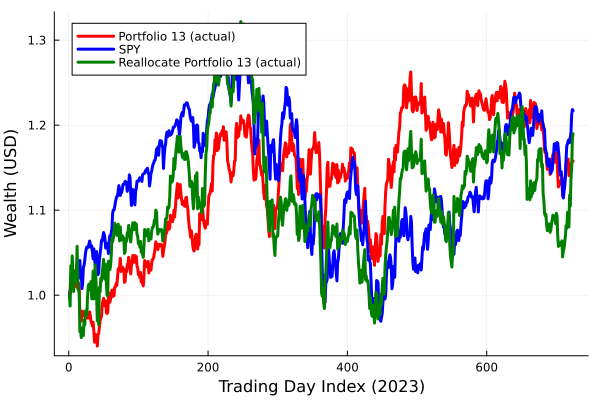

In [42]:
plot((1/portfolio_performance_array_original[1,end]).*portfolio_performance_array_original[:,end], 
    lw=3, c=:red, label="Portfolio $(portfolio_index) (actual)")
plot!((1/SPY_df[1,:volume_weighted_average_price]).*SPY_df[1:number_of_trading_days,:volume_weighted_average_price], lw=3, 
    c=:blue, label="SPY")
plot!((1/portfolio_performance_array_reallocate[1,end]).*portfolio_performance_array_reallocate[:,end], lw=3, 
    c=:green, label="Reallocate Portfolio $(portfolio_index) (actual)")
xlabel!("Trading Day Index (2023)", fontsize=18)
ylabel!("Wealth (USD)", fontsize=18)

### Compute `share_volume_array` 

In [43]:
share_volume_array = Array{Float64,2}(undef, number_of_trading_days+1, length(w)+1)

# initial (tday = 0)
share_volume_array[1,1] = 0;
for i ∈ eachindex(my_list_of_tickers)
    share_volume_array[1,i+1] = Nₒ[i]
end

for i ∈ 1:number_of_trading_days
    n_vector = my_results_df[i,:N_new]
    share_volume_array[i+1,1] = i;
    for j ∈ eachindex(n_vector)
        share_volume_array[i+1,j+1] = n_vector[j] |> x-> round(x,digits=3) |> abs
    end
end
header_data = Array{String,1}()
push!(header_data,"index");
[push!(header_data, ticker) for ticker ∈ my_list_of_tickers]
pretty_table(share_volume_array, header=header_data)

┌───────┬─────────┬─────────┬──────────┬────────┬────────┬─────────┐
│ index │     PFE │     MRK │      AMD │     MU │   INTC │     SPY │
├───────┼─────────┼─────────┼──────────┼────────┼────────┼─────────┤
│   0.0 │ 4.99008 │ 5.15245 │ 0.309252 │    0.0 │    0.0 │ 1.00498 │
│   1.0 │     0.0 │   3.123 │    6.814 │  1.553 │    0.0 │     0.0 │
│   2.0 │     0.0 │    1.28 │    9.126 │  0.813 │    0.0 │     0.0 │
│   3.0 │     0.0 │   6.479 │    4.413 │   0.96 │    0.0 │     0.0 │
│   4.0 │     0.0 │   4.183 │    5.573 │    0.0 │    0.0 │   0.407 │
│   5.0 │     0.0 │   8.076 │     3.32 │  0.286 │    0.0 │   0.053 │
│   6.0 │     0.0 │   5.137 │    4.907 │  1.705 │    0.0 │     0.0 │
│   7.0 │     0.0 │   1.592 │    1.888 │  1.027 │ 10.942 │     0.0 │
│   8.0 │     0.0 │   3.635 │    0.372 │   0.79 │  9.199 │   0.244 │
│   9.0 │     0.0 │   2.576 │      0.0 │  1.522 │ 11.869 │     0.0 │
│  10.0 │     0.0 │    4.45 │      0.0 │   2.63 │  7.545 │     0.0 │
│  11.0 │     0.0 │   2.229 │     

## Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.